### This notebook requires scikit-learn 0.23.2

In [1]:
!pip install scikit-learn==0.23.2 --user

  Using cached scikit_learn-0.23.2-cp38-cp38-win_amd64.whl (6.8 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.


In [2]:
import sklearn
sklearn.__version__

'0.23.2'

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
import catboost
import numpy as np
import gzip
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from imblearn.over_sampling import SMOTE, ADASYN

### Load dataset & check shape

In [4]:
loans = pd.read_csv('../data/Loan_status_2007-2020Q3.gzip', index_col = 0)

In [5]:
loans.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,1077501,5000.00000,5000.00000,4975.00000,36 months,10.65%,162.87000,B,B2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1077430,2500.00000,2500.00000,2500.00000,60 months,15.27%,59.83000,C,C4,Ryder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,1077175,2400.00000,2400.00000,2400.00000,36 months,15.96%,84.33000,C,C5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,1076863,10000.00000,10000.00000,10000.00000,36 months,13.49%,339.31000,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,1075358,3000.00000,3000.00000,3000.00000,60 months,12.69%,67.79000,B,B5,University Medical Group,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [6]:
loans.shape

(2925493, 141)

### Slice data for more recent loans to reduce scope & runtime

In [7]:
def filter_rows(data, date = "01-01-2018"):
    data['issue_d'] = pd.to_datetime(data['issue_d'])
    data = data.sort_values(by = 'issue_d')
    data = data[data["issue_d"] > date] 
    return data

In [8]:
loans = filter_rows(loans)
loans.shape

(1123719, 141)

### Drop Part 1: Drop features that have less than 80% of records (= more than 20% missing)

In [9]:
def drop_incomplete_features(data, miss_rate_tolerance = 0.7, exceptions = ['annual_inc_joint', 'dti_joint']):
    missing_fractions = data.isnull().mean().sort_values(ascending=False)
    missing_fractions.head()
    plt.close()
    plt.figure(figsize=(10,4.3))
    missing_fractions.plot.hist(bins=100)
    plt.title('Histogram of Feature Incompleteness')
    plt.xlabel('Fraction of data missing')
    plt.ylabel('Feature count')
    plt.axvline(x = miss_rate_tolerance, color = "r", linestyle = "--", label = "remove past this line")
    plt.legend()
    drop_list = sorted(list(missing_fractions[missing_fractions > miss_rate_tolerance].index)) ##### experiment with 0.25
    if exceptions:
        drop_list = [x for x in drop_list if x not in exceptions]
    print("\n\n Drop Features: ", len(drop_list))
    data.drop(labels=drop_list, axis=1, inplace=True)



 Drop Features:  32


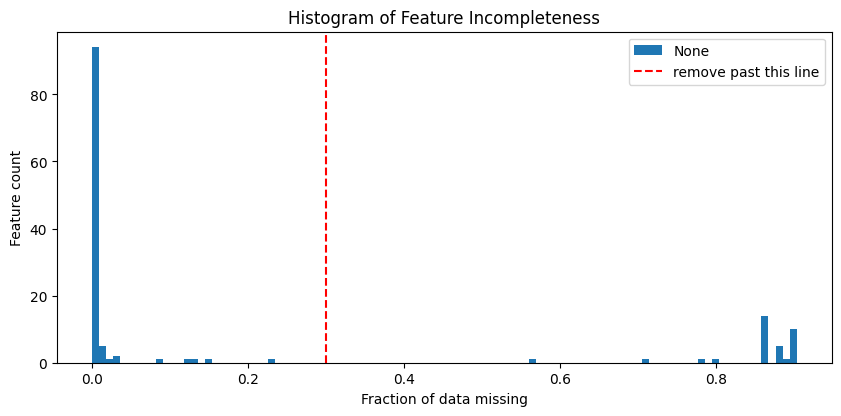

In [10]:
drop_incomplete_features(data = loans, miss_rate_tolerance = 0.3)

### Drop Part 2: Drop Columns of Features Not Known Prior to Funding (i.e., lookahead variables)

- These are variables that becomes populated after the origination and funding of the loan. In the stage of deciding approval, we cannot use these variables.
- Including these information will inflate our test AUC. A potential topic to elaborate on.

In [11]:
unknown_prior_to_funding = ['funded_amnt', 'funded_amnt_inv', 'url', "recoveries", "collection_recovery_fee",
               "total_rec_late_fee", "total_rec_int","total_rec_prncp", "out_prncp", "out_prncp_inv", "total_pymnt",
               "total_pymnt_inv", "last_pymnt_amnt","last_pymnt_d", "total_rec_late_fee",
               "pymnt_plan", "initial_list_status", "policy_code", 'chargeoff_within_12_mths', 
               'debt_settlement_flag', "hardship_flag", 'nb_of_payments', "next_pymnt_d", 
               "verification_status", 'verification_status_joint', 'issue_d']
graded = ['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'grade']

### The following variables will not be available for us to ingest at the time of application.
- Including the evenntual loan amount - which is determined based on credit policy on "approved loans". Will not inform us of default likelihood.

In [12]:
drop_list_2 = list(set(loans.columns) & set(unknown_prior_to_funding + graded))
print("Drop Features: ", len(drop_list_2))
drop_list_2

Drop Features:  29


['debt_settlement_flag',
 'sub_grade',
 'last_pymnt_amnt',
 'chargeoff_within_12_mths',
 'policy_code',
 'installment',
 'funded_amnt_inv',
 'last_pymnt_d',
 'funded_amnt',
 'int_rate',
 'total_rec_late_fee',
 'url',
 'initial_list_status',
 'next_pymnt_d',
 'term',
 'recoveries',
 'verification_status',
 'total_rec_int',
 'pymnt_plan',
 'collection_recovery_fee',
 'out_prncp',
 'issue_d',
 'total_pymnt_inv',
 'grade',
 'out_prncp_inv',
 'hardship_flag',
 'total_pymnt',
 'total_rec_prncp',
 'loan_amnt']

In [13]:
loans.drop(labels=drop_list_2, axis=1, inplace=True)

### Drop Part 3: EDA shows almost no correlation, else too specific to be helpful.
- annual_inc will be captured
- purpose variable can be included. Leaving out for now.

In [14]:
eda_drop = ["zip_code", 'emp_title', 'title', 'purpose']

In [15]:
loans.drop(eda_drop, axis=1, inplace=True)

In [16]:
print("Drop Features: 5")

Drop Features: 5


### Distribution of Target Variable:  Loan Outcome / Status

In [17]:
loans['loan_status'].value_counts(dropna=False)

Current               842623
Fully Paid            201217
Charged Off           56399 
Late (31-120 days)    11965 
In Grace Period       7264  
Issued                2062  
Late (16-30 days)     2009  
Default               180   
Name: loan_status, dtype: int64

Categories in percentage

### Cleaning before autoML experiment -- based on Kaggle EDA

- Numerical values that follow lognormal is later scaled with RobustScaler() and transformed using PowerTransformer()
- This eventually needs to go "inside" the pipeline, if we want to expose endpoint with similar raw input data.

In [18]:
def clean_columns(data):
    ### Change label to binary (default ? no default) from loan_status to default by item. Remove all "Current"
    data['loan_status'] = data['loan_status'].replace(to_replace = ['Late (31-120 days)', 'Default'], value = 'Charged Off')
    data = data.loc[data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    data['default'] = (data['loan_status'] == 'Charged Off').apply(np.uint8)
    # FICO reports high/low range. Combine by average
    data['ficoscore'] = 0.5*data['fico_range_low'] + 0.5*data['fico_range_high']
    data.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
    # These are lookahead variables, else redundant.
    data.drop(['last_fico_range_high', 'last_fico_range_low'], axis=1, inplace=True)
    # Clean percentage scores
    data['revol_util'] = data['revol_util'].map(lambda x: str(x).replace('%','')).astype(np.float64)
    # Clean string provided by emp_length
    data['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['emp_length'].replace('< 1 year', '0 years', inplace=True)
    data['emp_length'] = data['emp_length'].apply(lambda s: s if pd.isnull(s) else np.int8(s.split()[0]))
    # temporary: leave morgage account value as total acc if morgage account is non-negative
    total_acc_avg = data.groupby('total_acc').mean()['mort_acc'].fillna(0)
    data['mort_acc'] = data.apply(lambda x: total_acc_avg[x['total_acc']] if x['mort_acc'] >=0 else x['mort_acc'], axis=1)
    # Home_ownership - non-informative values - collapse into OTHER
    data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)
    # Utilize total length of credit history: provide interaction to account for upward mobility 
    data['last_credit_pull_d'] = pd.to_datetime(data['last_credit_pull_d'])
    data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
    data['time_since_earliest_cr_line'] = (data['last_credit_pull_d'] - data['earliest_cr_line']).dt.days
    data.drop(['earliest_cr_line'], axis=1, inplace=True)
    return data

### Check label distribution

In [19]:
loans = clean_columns(loans)
loans['loan_status'].value_counts(normalize=True, dropna=False)*100
loans.drop('loan_status', axis = 1, inplace = True)

### Load Benchmark Testset ID saved in .npy for fair evaluation

In [20]:
test_id = np.load("../data/test/lendingclub_testset_id.npy")
test_idx = loans["id"].isin(test_id)
test, train = loans[test_idx], loans[~test_idx]
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

### Pre-Pipeline column/feature list (69 columns)

In [21]:
set(train.columns)

{'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'collections_12_mths_ex_med',
 'default',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'dti_joint',
 'emp_length',
 'ficoscore',
 'home_ownership',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'last_credit_pull_d',
 'max_bal_bc',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'pct_tl_nvr_dlq',
 'percen

### Separate feature types for AutoML

In [22]:
numeric = set(loans.select_dtypes(include=np.number).columns) - set(['default'])
categorical = set(loans.columns) - set(loans.select_dtypes(include=np.number).columns) - set(['id', 'loan_status'])
high_categorical = [feature for feature in categorical if loans[feature].nunique() > 10]
categorical = categorical - set(high_categorical)
numeric, categorical = list(numeric), list(categorical)
label = 'default'
# numeric, categorical, high_categorical, label

### Save raw train/test data for team use

In [23]:
# cols = pd.concat([X_train, y_train], axis = 1).columns
X_train, y_train = train.drop(label, axis = 1), train[label]
X_test, y_test = test.drop(label, axis = 1), test[label]
X_train

,emp_length,home_ownership,annual_inc,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,ficoscore,time_since_earliest_cr_line
47856,3.00000,MORTGAGE,31000.00000,UT,30.04000,0.00000,0.00000,6.00000,0.00000,4775.00000,...,100.00000,100.00000,0.00000,0.00000,198277.00000,41191.00000,3800.00000,42562.00000,692.00000,3227.00000
47857,0.00000,MORTGAGE,135000.00000,GA,1.21000,0.00000,0.00000,9.00000,5.00000,8399.00000,...,100.00000,0.00000,0.00000,5.00000,42400.00000,8399.00000,37200.00000,0.00000,702.00000,5387.00000
47860,0.00000,RENT,57000.00000,MI,27.54000,0.00000,0.00000,6.00000,0.00000,24896.00000,...,100.00000,100.00000,0.00000,0.00000,50790.00000,41459.00000,27600.00000,23190.00000,707.00000,6118.00000
47862,4.00000,RENT,28000.00000,NE,23.83000,0.00000,0.00000,8.00000,0.00000,3326.00000,...,90.00000,0.00000,0.00000,0.00000,27369.00000,9838.00000,6100.00000,17269.00000,697.00000,3895.00000
47879,1.00000,OWN,57000.00000,PA,9.52000,0.00000,1.00000,16.00000,0.00000,1057.00000,...,93.30000,0.00000,0.00000,0.00000,202448.00000,26805.00000,30700.00000,25748.00000,737.00000,5144.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11518,10.00000,OWN,75000.00000,MI,19.54000,0.00000,0.00000,30.00000,0.00000,25666.00000,...,100.00000,36.40000,0.00000,0.00000,328363.00000,82024.00000,28400.00000,65799.00000,717.00000,8979.00000
10950,4.00000,RENT,51000.00000,SC,12.19000,0.00000,0.00000,5.00000,0.00000,784.00000,...,95.50000,0.00000,0.00000,0.00000,43624.00000,21248.00000,10100.00000,33524.00000,692.00000,3044.00000
12261,10.00000,MORTGAGE,125000.00000,CA,5.51000,0.00000,0.00000,11.00000,0.00000,2062.00000,...,96.70000,0.00000,0.00000,0.00000,431732.00000,23221.00000,23600.00000,30432.00000,757.00000,5479.00000
12536,10.00000,MORTGAGE,150000.00000,TX,18.03000,0.00000,0.00000,17.00000,0.00000,85060.00000,...,100.00000,30.00000,0.00000,0.00000,456245.00000,105807.00000,88000.00000,42545.00000,697.00000,6667.00000


### Check for data imbalance & prepare AdaSYN for upsampling minority class

In [24]:
np.unique(y_train, return_counts = True)

(array([0, 1], dtype=int8), array([191798,  67963], dtype=int64))

In [25]:
upsampler = ADASYN(sampling_strategy='minority')

### Check data examples

In [26]:
train.sample(n=3).T

,68167,128662,56805
emp_length,2.00000,10.00000,10.00000
home_ownership,OWN,RENT,RENT
annual_inc,78000.00000,43000.00000,50000.00000
addr_state,MI,NY,CA
dti,23.00000,15.02000,22.56000
...,...,...,...
total_bc_limit,53300.00000,5200.00000,14000.00000
total_il_high_credit_limit,54209.00000,18744.00000,28373.00000
default,0,0,1
ficoscore,797.00000,662.00000,677.00000


### AutoML Experiment: Sample 50,000 train datapoints for quick results - and input test set (10K)
- Normalize
- Power transform
- Impute
- encode categorical
- feature selection
- Fix imbalance
- remove outliers

In [27]:
from pycaret.classification import *

In [28]:
exp_name = setup(data = train.tail(n=50000),
                 test_data = test,
                 fix_imbalance = True,
                 normalize = True, 
                 normalize_method = 'robust',
                 transformation = True, 
                 ignore_low_variance = True,
                 remove_outliers = True,
                 categorical_features = categorical,
                 high_cardinality_features = high_categorical,
                 numeric_features = numeric,
                 numeric_imputation = 'median',
                 feature_selection = False,
                 feature_selection_method = "boruta",
                 feature_selection_threshold = 0.2,
                 # feature_interaction = True,
                 fix_imbalance_method = upsampler,
                 silent = True,
                 target = label)

,Description,Value
0,session_id,4607
1,Target,default
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(50000, 72)"
5,Missing Values,True
6,Numeric Features,67
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,True


### Check potential of predictability using basic models

In [29]:
top3 = compare_models(exclude = ["dummy","svm","ridge","qda","knn", "dt","nb","rf"], sort = "AUC", n_select = 3)
# top3 = compare_models(include = ["lr", "lda", "lightgbm", "catboost",'xgboost'], sort = "AUC", n_select = 4, cross_validation = False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7811,0.8025,0.4226,0.6034,0.4967,0.3625,0.3721,28.9490
lightgbm,Light Gradient Boosting Machine,0.7788,0.8015,0.4175,0.5972,0.4909,0.3556,0.3650,18.7830
xgboost,Extreme Gradient Boosting,0.7729,0.7921,0.4156,0.5790,0.4835,0.3431,0.3510,24.3860
gbc,Gradient Boosting Classifier,0.7656,0.7913,0.5118,0.5447,0.5272,0.3718,0.3724,29.4660
lr,Logistic Regression,0.7035,0.7887,0.7546,0.4528,0.5658,0.3613,0.3890,18.3040
lda,Linear Discriminant Analysis,0.6960,0.7884,0.7657,0.4456,0.5632,0.3540,0.3851,19.0670
et,Extra Trees Classifier,0.7648,0.7838,0.4403,0.5511,0.4892,0.3390,0.3427,20.9320
ada,Ada Boost Classifier,0.7403,0.7784,0.6074,0.4944,0.5448,0.3658,0.3698,20.8090


In [30]:
pd.concat([get_config('X_train'), get_config('y_train')], axis = 1).to_csv('train_cleaned.csv')
pd.concat([get_config('X_test'), get_config('y_test')], axis = 1).to_csv('test_cleaned.csv')

In [31]:
stacker13 = stack_models([top3[0],top3[0], top3[0],top3[0]], optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7604,0.7833,0.5320,0.5328,0.5324,0.3713,0.3713
1,0.7625,0.7924,0.5253,0.5378,0.5315,0.3725,0.3725
2,0.7527,0.7854,0.5170,0.5179,0.5174,0.3512,0.3512
3,0.7651,0.7922,0.5228,0.5436,0.5330,0.3761,0.3762
4,0.7627,0.7795,0.4863,0.5416,0.5125,0.3563,0.3572
5,0.7697,0.8006,0.5402,0.5522,0.5461,0.3919,0.3919
6,0.7668,0.8031,0.5494,0.5449,0.5471,0.3900,0.3901
7,0.7883,0.8295,0.5776,0.5888,0.5832,0.4413,0.4413
8,0.7885,0.8359,0.6257,0.5813,0.6027,0.4588,0.4594


In [32]:
stacker13

StackingClassifier(cv=5,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x00000296B0343400>),
                               ('catboost_1',
                                <catboost.core.CatBoostClassifier object at 0x00000296B0343B20>),
                               ('catboost_2',
                                <catboost.core.CatBoostClassifier object at 0x00000296B0343580>),
                               ('catboost_3',
                                <catboost.core.CatBoostClassifier object at 0x00000296B03435E0>)],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                    

In [33]:
top3[0].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 4607,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.06307300180196762,
 'score